In [21]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

### cleaned 데이터, 로지스틱 회귀

In [16]:
df = pd.read_csv('../../data/processed/sleep_cycle_productivity_cleaned.csv')

In [17]:
ordered_score = CategoricalDtype(categories=list(range(1, 11)), ordered=True)
for col in ['Sleep Quality', 'Productivity Score', 'Mood Score', 'Stress Level']:
    df[col] = df[col].astype(ordered_score)
df['Gender'] = df['Gender'].astype('category')
df['Weekday'] = df['Weekday'].astype('category')

df['Sleep_Quality_Binary'] = (df['Sleep Quality'] >= 5).astype(int)
y = df['Sleep_Quality_Binary']

X = df[['Age', 'Gender', 'Sleep Start Time', 'Sleep End Time',
        'Total Sleep Hours', 'Exercise (mins/day)',
        'Screen Time Before Bed (mins)', 'Work Hours (hrs/day)',
        'Productivity Score', 'Mood Score', 'Stress Level', 'Weekday']]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['Gender', 'Weekday']

In [19]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

pipeline = make_pipeline(preprocessor, LogisticRegression())

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.2, random_state=5)
pipeline.fit(X_train_c, y_train_c)
y_pred_c = pipeline.predict(X_test_c)

print("[Cleaned Data] Accuracy:", accuracy_score(y_test_c, y_pred_c))

# ROC-AUC 계산
y_prob_c = pipeline.predict_proba(X_test_c)[:, 1]
auc_clean = roc_auc_score(y_test_c, y_prob_c)
print("[Cleaned Data] ROC-AUC:", round(auc_clean, 4))

[Cleaned Data] Accuracy: 0.577
[Cleaned Data] ROC-AUC: 0.4969


### PCA+군집 데이터, 로지스틱 회귀

In [7]:
df_pca = pd.read_csv('../../data/processed/3_pca_cluster_data.csv')

In [14]:
X = df_pca.drop('Sleep_Quality_Binary', axis=1)
y = df_pca['Sleep_Quality_Binary']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.2, random_state=5)

model = LogisticRegression()
model.fit(X_train_p, y_train_p)
y_pred_p = model.predict(X_test_p)

print("[PCA + Cluster] Accuracy:", accuracy_score(y_test_p, y_pred_p))

# ROC-AUC 계산
y_prob_p = model.predict_proba(X_test_p)[:, 1]
auc_pca = roc_auc_score(y_test_p, y_prob_p)
print("[PCA + Cluster] ROC-AUC:", round(auc_pca, 4))

[PCA + Cluster] Accuracy: 0.6
[PCA + Cluster] ROC-AUC: 0.4972


### 두 로지스틱 ROC-AUC 비교

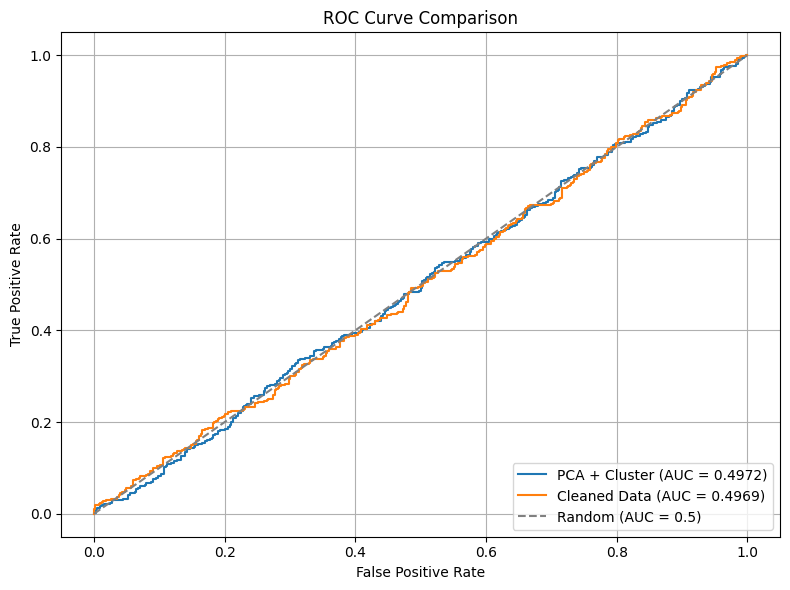

In [22]:
fpr_pca, tpr_pca, _ = roc_curve(y_test_p, y_prob_p)
fpr_clean, tpr_clean, _ = roc_curve(y_test_c, y_prob_c)

# AUC 계산
auc_pca = auc(fpr_pca, tpr_pca)
auc_clean = auc(fpr_clean, tpr_clean)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr_pca, tpr_pca, label=f'PCA + Cluster (AUC = {auc_pca:.4f})')
plt.plot(fpr_clean, tpr_clean, label=f'Cleaned Data (AUC = {auc_clean:.4f})')

# 무작위 예측 기준선
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

AUC가 0.5 근처:	모델이 실제로는 타겟(수면의 질)과 구분 능력이 없음

두 모델 성능 차이:	0.0003 차이 → 전혀 의미 없음 (실질적으로 동일한 모델)

$\mathbf{\Rightarrow 두\ 모델\ 모두\ 구분\ 능력이\ 없는\ 상태}$